In [14]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Vectorize Vertex and Spektral

### KERNEL --> Spektral 
### Classifier --> Spektral
### Node_features = Vectorize Vertex(n_bits = 2,4,6,8,10,12,14,16,18)

In [15]:
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

from spektral.datasets import delaunay
from spektral.layers import GraphAttention, GlobalAvgPool
from spektral.utils import localpooling_filter


In [16]:
import load_data as ld
import utilities as ut
from sklearn.model_selection import StratifiedKFold
import numpy as np
import dataset_statistics as ds

In [17]:
n_bits = [2,3,4,5,6,8,10]
n_times = 5
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR

acc, loss = run(name,n_bits,n_times,prot=False)


 LEUKEMUA


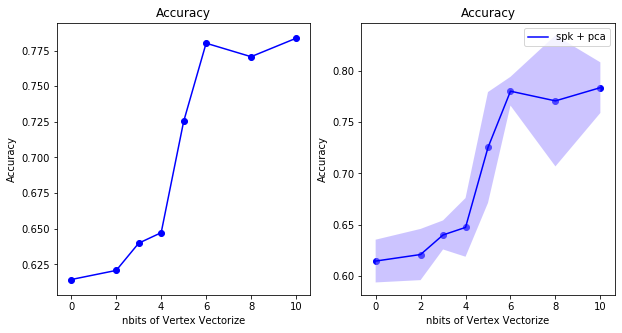


 CANCER


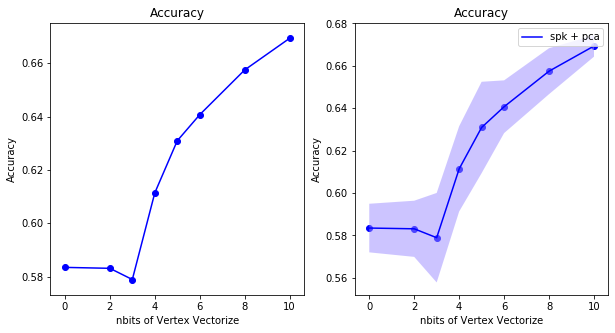


 AIDS


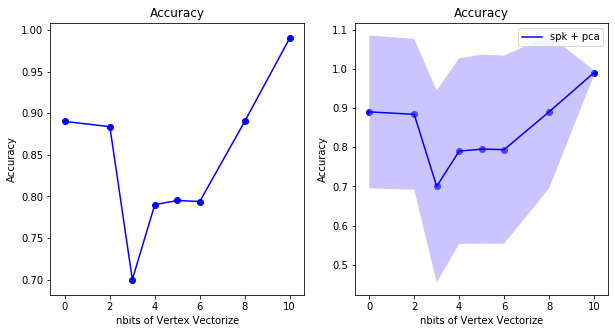


 DHFR


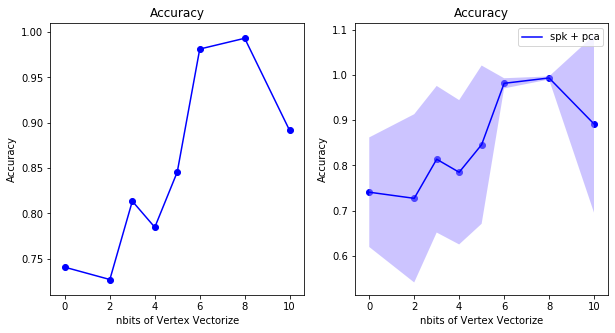


 PROTEINS


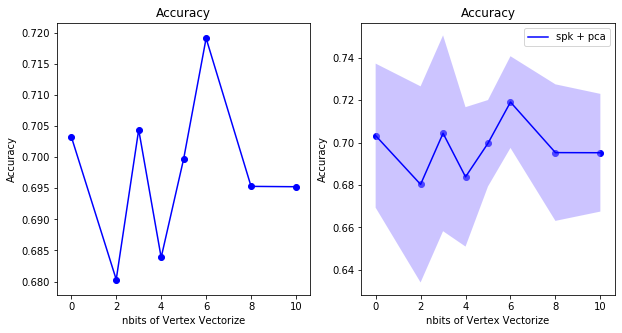

In [23]:
# results
print("\n LEUKEMUA")
plot_nbits(acc_leuk,n_bits)
print("\n CANCER")
plot_nbits(acc_canc,n_bits)
print("\n AIDS")
plot_nbits(acc_aids,n_bits)
print("\n DHFR")
plot_nbits(acc_dhfr,n_bits)
print("\n PROTEINS")
plot_nbits(acc_prot,n_bits)

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

def run(name,param,n_times,prot=False):
    acc = []
    loss = []
    
    graphs,labels = ld.load_data_pubchem(name)
    graphs = np.array(graphs)
    labels = np.array(labels)
    print("no Vectorize:")
    res_acc, res_loss = repeat_n_times(graphs,labels,n_times)
    acc.append(res_acc)
    loss.append(res_loss)
    
    print(acc)
    
    
    for i in param:
        print("si Vectorize - n_bits = "+str(i))
        #graphs,labels = ld.load_data(name)
        if(prot==True):
            graphs_in,labels_in = ld.load_data_pubchem(name)
            grpahs_in = np.array(graphs_in)
            print("sto eliminado i grafi grandi")
            graphs = []
            labels = []
            for j in range(len(graphs_in)):
                n_nodes = graphs_in[j].number_of_nodes() 
                if (n_nodes < 150):
                    graphs.append(graphs_in[j])
                    labels.append(labels_in[j])
            print(len(graphs))
        else:
            print("normal load")
            graphs,labels = ld.load_data_pubchem(name)

        graphs = np.array(graphs)
        labels = np.array(labels)

        func = [ut.vec_vertex]
        graphs = ut.add_info_to_nodes(graphs,func,param=i)
        res_acc, res_loss = repeat_n_times(graphs,labels,n_times)
        acc.append(res_acc)
        loss.append(res_loss)
        
        print(acc)
    return(acc,loss)

def repeat_n_times(graphs,labels,n_times):
    graphs = np.array(graphs)
    adj, x , _ = ut.from_nx_to_adj(graphs)
    kFold = StratifiedKFold(n_splits=n_times)
    r_acc = []
    r_loss = []
    c = 0
    for train, test in kFold.split(adj, labels):
        c = c +1
        print("\t fold:"+str(c))
        loss, acc = spk_train_test(adj[train],x[train], labels[train],adj[test],x[test], labels[test])
        r_acc.append(acc)
        r_loss.append(loss)
    return(r_acc,r_loss)

def spk_train_test(adj_train,x_train,labels_train,adj_test,x_test, labels_test):
    
    y_train = ut.from_np_to_one_hot(labels_train)
    y_test = ut.from_np_to_one_hot(labels_test)
    
    
    
    # Parameters
    N = x_train.shape[-2]           # Number of nodes in the graphs
    F = x_train.shape[-1]           # Original feature dimensionality
    n_classes = y_train.shape[-1]   # Number of classes
    l2_reg = 5e-4             # Regularization rate for l2
    learning_rate = 1e-3      # Learning rate for Adam
    epochs = 200              # Number of training epochs
    batch_size = 32           # Batch size
    es_patience = 25          # Patience fot early stopping



    # Preprocessing
    fltr_train = localpooling_filter(adj_train.copy())
    fltr_test = localpooling_filter(adj_test.copy())

    # Model definition
    X_in = Input(shape=(N, F))
    filter_in = Input((N, N))

    gc1 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, filter_in])
    gc2 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, filter_in])
    gc3 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc2, filter_in])
    pool = GlobalAvgPool()(gc3)

    output = Dense(n_classes, activation='softmax')(pool)

    # Build model
    model = Model(inputs=[X_in, filter_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])



    # Callbacks
    es_callback = EarlyStopping(monitor='val_acc', patience=es_patience)

    # Train model
    model.fit([x_train, fltr_train],
              y_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs,
              verbose = 0,
              callbacks=[es_callback])

    # Evaluate model
    eval_results = model.evaluate([x_test, fltr_test],
                                  y_test,
                                  verbose = 0,
                                  batch_size=batch_size)
    
    return (eval_results[0],eval_results[1])


def  plot_nbits(metric,n_bits,text="Accuracy"):
    n_bits = [0] + n_bits
    mean = []
    std = []
    for i in metric:
        mean.append(np.mean(i))
        std.append(np.std(i))
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title(text)
    plt.plot(n_bits,mean, label='spk + pca',color='b')
    plt.scatter(n_bits,mean,color='b')
    plt.xlabel("nbits of Vertex Vectorize")
    plt.ylabel("Accuracy")


    plt.subplot(122)
    plt.title(text)
    plt.plot(n_bits,mean, label='spk + pca',color='b')
    plt.scatter(n_bits,mean,color='b')
    low = [mean[i]-std[i] for i in range(0,len(mean))] 
    upp = [mean[i]+std[i] for i in range(0,len(mean))]
    plt.fill_between(n_bits,low,upp, facecolor='#9B8BFF', alpha=0.5)
    plt.xlabel("nbits of Vertex Vectorize")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()





In [22]:
### data 

acc_leuk = [[0.5931372549019608,
  0.6421568633294573,
  0.6176470599922479,
  0.5882352952863655,
  0.6305418719211823],
 [0.6127450968704972,
  0.6446078425528956,
  0.615196077262654,
  0.580882354109895,
  0.6502463048314814],
 [0.6470588246981303,
  0.6593137266589146,
  0.6274509815608754,
  0.6200980380469677,
  0.6453201964570972],
 [0.6078431372549019,
  0.6838235294117647,
  0.6715686262822619,
  0.6225490196078431,
  0.6502463048314814],
 [0.6397058823529411,
  0.6838235305804833,
  0.7794117658746009,
  0.7598039215686274,
  0.7635467968550809],
 [0.7647058811842227,
  0.7965686286196989,
  0.7867647047136345,
  0.7622549019607843,
  0.7906403955567647],
 [0.8063725478508893,
  0.7818627439293206,
  0.7990196090118558,
  0.8210784325412676,
  0.6453201982188107],
 [0.794117645890105,
  0.7671568639138165,
  0.7892156874432283,
  0.7475490196078431,
  0.8201970449222132]]

acc_canc = [[0.5871080135219189,
  0.5627177694117982,
  0.5944055931551473,
  0.5926573424489348,
  0.5804195797943569],
 [0.5871080131065555,
  0.5644599296905438,
  0.5874125861621403,
  0.6031468529384453,
  0.573426572592942],
 [0.5818815326856819,
  0.573170731084272,
  0.5681818194322653,
  0.6171328675496829,
  0.5541958033621728],
 [0.5923344943581558,
  0.6236933787525323,
  0.6276223780391933,
  0.6311188811188811,
  0.5821678325846479],
 [0.6167247380529132,
  0.65331010369889,
  0.5979020974852822,
  0.6538461542629695,
  0.6328671328671329],
 [0.6324041803539422,
  0.6585365849504903,
  0.6258741258741258,
  0.6520979012642707,
  0.6346153833649375],
 [0.6567944242563812,
  0.6480836245241065,
  0.643356642523012,
  0.6678321665817207,
  0.6713286725791184],
 [0.6707317081477999,
  0.6637630657867272,
  0.6783216795721254,
  0.6678321678321678,
  0.6660839169175474]]

acc_aids = [[1.0, 0.975, 0.5, 0.9875, 0.9875],
 [0.99375, 0.98125, 0.5, 0.9875, 0.95625],
 [1.0, 0.5, 1.0, 0.5, 0.5],
 [0.9875, 0.975, 0.9875, 0.5, 0.5],
 [0.99375, 0.98125, 1.0, 0.5, 0.5],
 [0.9875, 0.5, 0.99375, 0.5, 0.9875],
 [0.9875, 0.975, 1.0, 0.5, 0.9875],
 [0.9875, 0.98125, 1.0, 0.9875, 0.99375]]


acc_dhfr = [[0.7966101705017736,
  0.8050847447524636,
  0.5,
  0.8220339003255812,
  0.7796610209901454],
 [0.5000000030307447,
  0.855932205410327,
  0.5,
  0.8813559372546309,
  0.8983050867662592],
 [0.9237288105285774,
  0.9067796660681903,
  0.5,
  0.8135593210236501,
  0.9237288105285774],
 [0.9576271236953089,
  0.737288138623965,
  0.8898305084745762,
  0.838983052867954,
  0.4999999989897518],
 [0.9576271156133231,
  0.9067796660681903,
  0.5,
  0.8983050847457628,
  0.9661016918845096],
 [1.0,
  0.9830508474576272,
  0.9830508474576272,
  0.9661016949152542,
  0.9745762762376817],
 [1.0,
  0.9915254237288136,
  0.9915254237288136,
  0.9915254237288136,
  0.9915254237288136],
 [1.0,
  0.5000000010102482,
  0.9830508474576272,
  0.9915254237288136,
  0.9830508444268825]]


acc_prot = [[0.6875, 0.6818181818181818, 0.7142857153075082, 0.6685714292526245, 0.7643678174621757],[0.7329545454545454,
  0.6818181818181818,
  0.697142858845847,
  0.5942857149669102,
  0.6954023002207964],
 [0.7272727272727273,
  0.6761363636363636,
  0.7142857156481062,
  0.6342857149669102,
  0.7701149411585139],
 [0.6590909090909091,
  0.6647727272727273,
  0.6514285727909633,
  0.7371428581646511,
  0.7068965503539162],
 [0.7386363636363636,
  0.6988636363636364,
  0.6914285724503654,
  0.6800000010217939,
  0.6896551737840149],
 [0.75,
  0.7102272727272727,
  0.7085714299338205,
  0.737142858845847,
  0.689655173098904],
 [0.6875,
  0.6704545454545454,
  0.7142857153075082,
  0.657142858505249,
  0.7471264354113875],
 [0.7102272727272727,
  0.6875,
  0.6914285731315613,
  0.6514285724503653,
  0.7356321845931568]] 